In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


TIMEOUT: ignored

In [0]:
# import necessary libraries and modules
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import json
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# Load json file
with open('gdrive/My Drive/categories.json') as file:
  data = json.load(file)

{'BB & CC Cream': 5,
 'Blush On': 2,
 'Bronzer': 11,
 'Concealer': 7,
 'Contour': 6,
 'Face Palette': 0,
 'Foundation': 1,
 'Highlighter': 8,
 'Lip Gloss': 14,
 'Lip Liner': 15,
 'Lip Tint': 13,
 'Lipstick': 12,
 'Other Face Cosmetics': 4,
 'Other Lip Cosmetics': 16,
 'Powder': 3,
 'Primer': 9,
 'Setting Spray': 10}

In [0]:
# Load dataset
df = pd.read_csv('gdrive/My Drive/train.csv')
beauty = df[df['image_path'].apply(lambda x: x.startswith('beauty'))]
beauty.head()

(286583, 4)


,itemid,title,Category,image_path
0,307504,nyx sex bomb pallete natural palette,0,beauty_image/6b2e9cbb279ac95703348368aa65da09.jpg
1,461203,etude house precious mineral any cushion pearl...,1,beauty_image/20450222d857c9571ba8fa23bdedc8c9.jpg
2,3592295,milani rose powder blush,2,beauty_image/6a5962bed605a3dd6604ca3a4278a4f9.jpg
3,4460167,etude house baby sweet sugar powder,3,beauty_image/56987ae186e8a8e71fcc5a261ca485da.jpg
4,5853995,bedak revlon color stay aqua mineral make up,3,beauty_image/9c6968066ebab57588c2f757a240d8b9.jpg


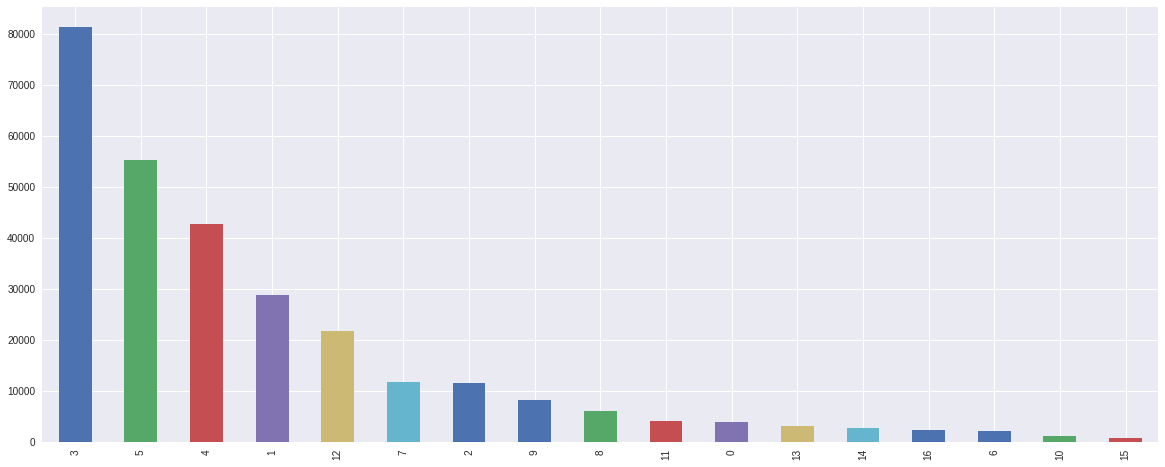

In [0]:
# Plot graph to see the numbers of each category
beauty['Category'].value_counts().plot.bar(figsize=(20, 8))

In [0]:
# Preprocessing titles
import re
def find_word(title, words):
  test_cases = [0]*len(words)
  for i in range(len(words)):
    if re.search(r'\b{}\b'.format(words[i]), title):
      test_cases[i] = True
    else:
      test_cases[i] = False
  return all(test_cases)

def find_title_words(data, words):
  data_x = data[data['title'].apply(lambda x: find_word(x, words))]
  return data_x


def change_category(x, words, to_change, not_to_change):
  lower_words = [word.lower() for word in words]
  if x['Category'] not in not_to_change and find_word(x['title'], lower_words):
    return to_change
  else:
    return x['Category']

In [0]:
beauty['Category'] = beauty.apply(lambda x: change_category(x, ['spray'], 10, []), axis=1)

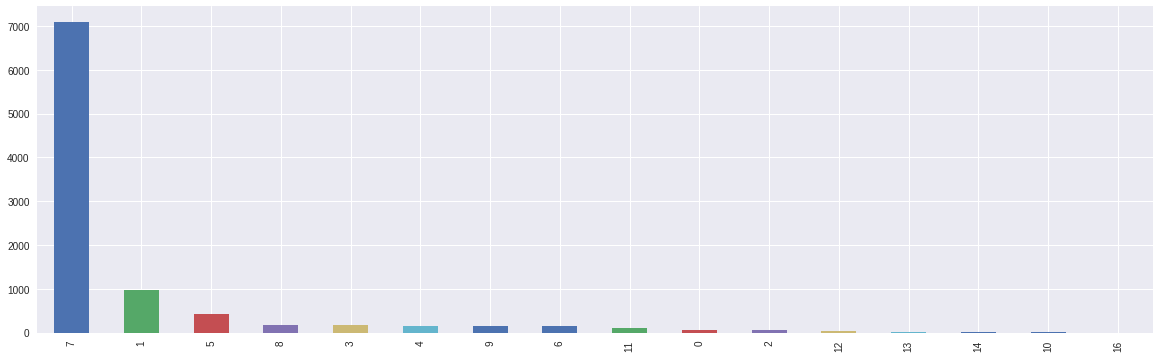

In [0]:
d = find_title_words(beauty, ['concealer'])
d['Category'].value_counts().plot.bar(figsize=(20,6))

In [0]:
# See most common words in fashion df
print('beauty items:', beauty.shape[0])
beauty_dict= {}
beauty_titles = beauty['title']
for title in beauty_titles:
  words = title.split(' ')
  for word in words:
    if word in beauty_dict:
      beauty_dict[word] += 1
    else:
      beauty_dict[word] = 1
      
ordered_list = list(sorted(beauty_dict.items(), key = lambda x: x[1], reverse = True))
# ordered_list[:40]

import math
def display_top_words(top_words):
  rows = 10
  cols = math.ceil(len(top_words) / 10.0)
  a = 0
  for row in range(rows):
    words = top_words[row::10]
    for word in words:
      string = word[0] + ': ' + str(word[1])
      print('{: >20}'.format(string), end='\t')
    print('\n')
    
display_top_words(ordered_list[:50])

beauty items: 286583
        cream: 74436	          lip: 16630	        house: 11815	     concealer: 9517	      terlaris: 8471	

       powder: 62796	         face: 16262	         make: 11621	       mineral: 9494	      lipstick: 8384	

           bb: 35959	      natural: 15556	         pink: 11586	         blush: 9419	           nyx: 8159	

      cushion: 31834	        etude: 14096	           pa: 11346	       bioaqua: 9395	      termurah: 8152	

        bedak: 25287	        promo: 13958	        loose: 11242	         white: 9365	            up: 8123	

     original: 23803	       liquid: 13697	         acne: 10479	        refill: 9348	         stick: 8038	

        matte: 21446	        murah: 13103	   maybelline: 10024	          glow: 9234	            no: 7848	

   foundation: 21100	          the: 12462	         light: 9937	          skin: 8989	            in: 7795	

          spf: 20061	          new: 12348	         magic: 9873	          balm: 8690	        diskon: 7725	

       wardah: 1

In [0]:
# Process raw titles
import re

drop_list = ['promo', 'no', 'in']
def drop_word(x, drop_list):
  y = re.sub('[0-9]{1,}\s*(ml)', ' ', x)               # drop x ml
  y = re.sub('[0-9]+(.[0-9]+)*', ' ', y)               # drop numbers
  for word in drop_list:
    y = re.sub(r'\b{}\b'.format(word), ' ', y)         # drop words in drop_list
  y = re.sub('\s+', ' ', y)                            # drop multiple space
  if y[0] == ' ':                                      # drop first and last space (if it was there)
    y = y[1:]
  if y[-1] == ' ':
    y = y[:-1]
  return y

new_titles = beauty['title'].apply(lambda x: drop_word(x, drop_list))

In [0]:
# See most common words in fashion df
print('beauty items:', beauty.shape[0])
beauty_dict_3 = {}
beauty_titles_3 = new_titles
for title in beauty_titles_3:
  words = title.split(' ')   
  for word in words:
    if word in beauty_dict_3:
      beauty_dict_3[word] += 1
    else:
      beauty_dict_3[word] = 1
      
ordered_list = list(sorted(beauty_dict_3.items(), key = lambda x: x[1], reverse = True))s

display_top_words(ordered_list[:50])

beauty items: 286583
        cream: 74454	          lip: 16631	           cc: 11888	     concealer: 9522	      terlaris: 8471	

       powder: 62809	         face: 16282	        house: 11815	       mineral: 9494	      lipstick: 8385	

           bb: 36014	      natural: 15591	         make: 11621	         blush: 9419	           nyx: 8161	

      cushion: 31852	        etude: 14097	         pink: 11593	       bioaqua: 9397	      termurah: 8152	

          spf: 26984	       liquid: 13698	        loose: 11242	         white: 9366	            up: 8124	

        bedak: 25290	        murah: 13105	         acne: 10479	        refill: 9361	         stick: 8040	

     original: 23835	           gr: 12698	   maybelline: 10024	          glow: 9236	             g: 7848	

        matte: 21447	          the: 12463	         light: 9962	          skin: 9126	        diskon: 7733	

   foundation: 21108	          new: 12351	         magic: 9873	          balm: 8694	         wajah: 7547	

       wardah: 1

In [0]:
def find_frequency_words(words):
  for word in words:
    num = 0
    for title in new_titles:
      if re.search(r'\b{}\b'.format(word), title):
        num += 1
    print(word, ":", num)

frequency_list = ['white', 'black', 'yellow', 'orange', ' pink']
find_frequency_words(frequency_list)

white : 9372
black : 3929
yellow : 408
orange : 678
 pink : 11456


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

cntvt = CountVectorizer(ngram_range=(1,3), max_features = 8000, min_df=5)
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features = 8000, min_df=5)
x_train_tf = tfidf.fit_transform(new_titles)
x_train_cv = cntvt.fit_transform(new_titles)

from sklearn.model_selection import train_test_split
x_tf_train, x_tf_test, y_tf_train, y_tf_test = train_test_split(x_train_tf, beauty['Category'], test_size=0.2)
x_cv_train, x_cv_test, y_cv_train, y_cv_test = train_test_split(x_train_cv, beauty['Category'], test_size=0.2)

In [0]:
# neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(1000, activation='relu', input_shape=(8000,)))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(17, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs = 1)

test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/1
57317/57317 [==============================] - 27s 474us/step
Test accuracy: 0.7584660746375421


In [0]:
# Save model
model.save('gdrive/My Drive/beauty_model.h5')

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

c_space = np.linspace(0.5, 1.4, 10)
param_grid = {'C':c_space}
tfidf_SVC = LinearSVC(C=1)
tfidf_SVC.fit(x_tf_train, y_tf_train)
print('TF - IDF')
print('Training set accuracy:', tfidf_SVC.score(x_tf_train, y_tf_train))
print('Test set accuracy:', tfidf_SVC.score(x_tf_test, y_tf_test))
# tfidf_grid = GridSearchCV(SVC, param_grid, cv=5)
# tfidf_grid.fit(x_tf_train, y_tf_train)
# print('Best parameter:', tfidf_grid.best_params_)
# print('Best accuracy:', tfidf_grid.best_score_)

TF - IDF
Training set accuracy: 0.78718170160425
Test set accuracy: 0.7661950206744945


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

c_space = np.linspace(0.5, 1.4, 10)
param_grid = {'C':c_space}
cntvt_SVC = LinearSVC(C=1)
cntvt_SVC.fit(x_tf_train, y_tf_train)
print('CountVectorizer')
print('Training set accuracy:', cntvt_SVC.score(x_cv_train, y_cv_train))
print('Test set accuracy:', cntvt_SVC.score(x_cv_test, y_cv_test))
# tfidf_grid = GridSearchCV(SVC, param_grid, cv=5)
# tfidf_grid.fit(x_tf_train, y_tf_train)
# print('Best parameter:', tfidf_grid.best_params_)
# print('Best accuracy:', tfidf_grid.best_score_)

CounVectorizer
Training set accuracy: 0.7649455217956435
Test set accuracy: 0.76272310134864


In [0]:
test = pd.read_csv('gdrive/My Drive/test.csv')
beauty_test = test[test['image_path'].apply(lambda x: x.startswith('beauty'))]

(76545, 3)

In [0]:
new_test_titles = beauty_test['title'].apply(lambda x: drop_word(x, drop_list))

In [0]:
x2_cntvt = cntvt.transform(new_test_titles)
x2_tfidf = tfidf.transform(new_test_titles)

In [0]:
cntvt_labels = cntvt_SVC.predict(x2_cntvt)
tfidf_labels = tfidf_SVC.predict(x2_tfidf)

In [0]:
beauty_cntvt_submit = pd.DataFrame({'itemid': beauty_test['itemid'], 'Category': cntvt_labels}, columns=['itemid', 'Category'])
beauty_cntvt_submit.to_csv('beauty_cntvt_submit.csv')

In [0]:
beauty_tfidf_submit = pd.DataFrame({'itemid': beauty_test['itemid'], 'Category': tfidf_labels}, columns=['itemid', 'Category'])
beauty_tfidf_submit.to_csv('beauty_tfidf_submit.csv')